Requires notebook 6 and [slide_stats.ipynb](./slide_stats.ipynb).

In [5]:
suppressPackageStartupMessages({
  library(dplyr)
  library(cowplot)
  library(magrittr)
  library(dataorganizer)
  library(pagoda2)
  library(ggrepel)
  library(data.table)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

ℹ Loading cellAdmixNotebooks


In [2]:
# load markers
all_markers <- DatasetPath('human_ovarian_cancer', 'processed', 'OC_markers_sub.csv') %>% read.csv()
all_markers <- all_markers[,c('Gene','cell_type')]
colnames(all_markers) <- c('gene','marker_of')

g_rem <- all_markers$gene[duplicated(all_markers$gene)]
all_markers <- all_markers[!(all_markers$gene %in% g_rem),]

all_markers_list <- lapply(unique(all_markers$marker_of),function(x){
  return(all_markers$gene[all_markers$marker_of==x])
})
names(all_markers_list) <- unique(all_markers$marker_of)

In [ ]:
# load counts version of org and clean data
so_spatial_orig <- DatasetPath('human_ovarian_cancer','processed','so.rds') %>% readRDS()
so_spatial_cln <- CachePath('OC_scaled_dat6','so_spatial_cln_20_full.rds') %>% readRDS()

dat_orig <- so_spatial_orig[['RNA']]$counts
meta_orig <- so_spatial_orig@meta.data

dat_cln <- so_spatial_cln[['RNA']]$counts
meta_cln <- so_spatial_cln@meta.data

# subset data to same cells
cells_both <- intersect(colnames(dat_orig),colnames(dat_cln))
dat_orig <- dat_orig[,cells_both]
dat_cln <- dat_cln[,cells_both]
meta_orig <- meta_orig[cells_both,]

# append xy cell centroids
data <- prepare_OC_sc_spatial()
cell_annot <- data[[2]]
meta_orig <- cbind.data.frame(meta_orig,cell_annot[rownames(meta_orig),c('x','y')])

# appending region annotations
spat_clust <- CachePath('OC_spatial_clustering.rds') %>% readRDS()
meta_orig$niche <- spat_clust[rownames(meta_orig),'spat_clust']
meta_cln$niche <- spat_clust[rownames(meta_cln),'spat_clust']

In [14]:
unique(meta_orig$cell_type)

[1] "Proliferative Tumor Cells"      "Tumor Cells"                   
 [3] "Ciliated Epithelial Cells"      "Inflammatory Tumor Cells"      
 [5] "Macrophages"                    "T & NK Cells"                  
 [7] "Tumor Associated Fibroblasts"   "VEGFA+ Tumor Cells"            
 [9] "Malignant Cells Lining Cyst"    "Endothelial Cells"             
[11] "Fallopian Tube Epithelium"      "Stromal Associated Fibroblasts"
[13] "Smooth Muscle Cells"            "Granulosa Cells"               
[15] "Pericytes"

In [26]:
subset_cell_ct_region <- function(dat,meta,cell_type) {
    # subset to just one cell type
    cells_keep <- rownames(meta)[meta$cell_type==cell_type]
    meta <- meta[cells_keep,]
    dat <- dat[,cells_keep]

    # add annotation for regions to compare with de
    meta$regions_compare <- sapply(meta$niche,function(x) {
      if (x%in%c(2,4,5)) {
        return('tumor')
      } else if (x%in%c(1,3)) {
        return('stroma')
      } else {
        return(NA)
      }
    })

    # reduce data to just the cells in the tested regions
    cells_keep <- rownames(meta)[!is.na(meta$regions_compare)]
    meta <- meta[cells_keep,]
    dat <- dat[,cells_keep]
    return(list(dat,meta))
}
orig_sub <- subset_cell_ct_region(dat_orig,meta_orig,cell_type='Macrophages')
dat_orig <- orig_sub[[1]]
meta_orig <- orig_sub[[2]]

cln_sub <- subset_cell_ct_region(dat_cln,meta_cln,cell_type='Macrophages')
dat_cln <- cln_sub[[1]]
meta_cln <- cln_sub[[2]]

In [28]:
## run de for original counts
dat_pgda_orig <- basicP2proc(dat_orig, n.cores=1, min.cells.per.gene=0,
                            n.odgenes=2e3, get.largevis=FALSE, make.geneknn=FALSE)
regions_compare <- meta_orig$regions_compare
names(regions_compare) <- rownames(meta_orig)
de_out_orig <- dat_pgda_orig$getDifferentialGenes(verbose=TRUE,groups=regions_compare,z.threshold = 0,
                                            upregulated.only=FALSE,append.auc = TRUE)
de_out_orig <- de_out_orig[['tumor']]

21791 cells, 5101 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

59 overdispersed genes ... 59

persisting ... 

done.

running PCA using 2000 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


running tSNE using 1 cores:


running differential expression with 2 clusters ... 

adjusting p-values ... 

done.




In [30]:
names(all_markers_list)

[1] "Inflammatory Tumor Cells"       "Ciliated Epithelial Cells"     
 [3] "Tumor Associated Fibroblasts"   "Proliferative Tumor Cells"     
 [5] "Macrophages"                    "Smooth Muscle Cells"           
 [7] "Endothelial Cells"              "Malignant Cells Lining Cyst"   
 [9] "Stromal Associated Fibroblasts" "VEGFA+ Tumor Cells"            
[11] "Granulosa Cells"                "Pericytes"                     
[13] "Tumor Cells"                    "T & NK Cells"

Warning message:
“Removed 5094 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


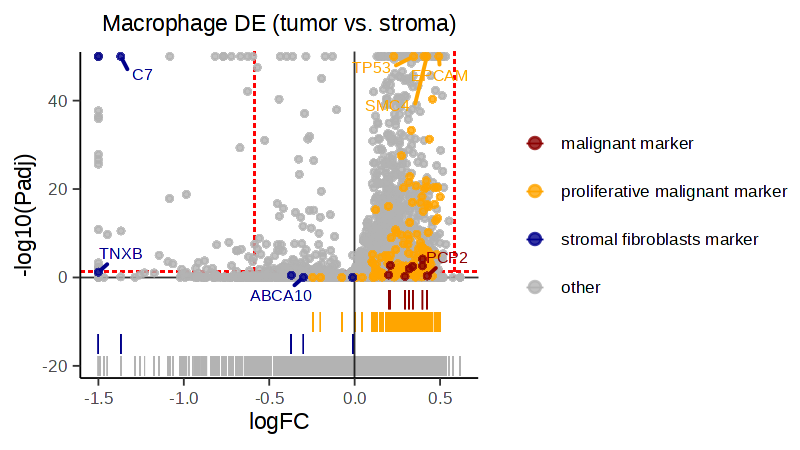

In [88]:
options(repr.plot.width = 4, repr.plot.height = 2.25, repr.plot.res = 200)
# options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 200)

## making volcano plot for original DE
de_out_orig$padj <- 2*pnorm(abs(de_out_orig$Z), mean = 0, sd = 1, lower.tail = FALSE) # convert z back to padj

de_out_orig$mark_other <- sapply(de_out_orig$Gene,function(x){
  if (x %in% all_markers_list[['Tumor Cells']]) {
    return('malignant marker')
  } else if (x %in% all_markers_list[['Proliferative Tumor Cells']]) {
    return('proliferative malignant marker')
  } else if (x %in% all_markers_list[['Stromal Associated Fibroblasts']]) {
    return('stromal fibroblasts marker')
  } else {
    return('other')
  }
})


de_out_orig$logpv <- -log10(de_out_orig$padj)
genes_to_label <- c('SMC4','TP53','EPCAM','PCP2','ABCA10','C7','TNXB')

# genes_to_label <- all_markers_list[['Proliferative Tumor Cells']]

ndx_lab <- which(de_out_orig$Gene %in% genes_to_label)
de_out_orig$top_mark_other <- NA
de_out_orig[ndx_lab,'top_mark_other'] <- de_out_orig$Gene[ndx_lab]
de_out_orig$logpv[de_out_orig$logpv>50] <- 50
ymax <- max(de_out_orig$logpv,na.rm=TRUE) + 1
myColors <- c('red4','orange','blue4','grey70')

# Helper variables
limits <- range(de_out_orig$logpv,na.rm = TRUE,finite = TRUE)
step   <- diff(limits) * 0.1
size   <- 0.45 * step
dpi=1400
de_out_orig$mark_other <- factor(de_out_orig$mark_other,levels=c('malignant marker','proliferative malignant marker','stromal fibroblasts marker','other'))
de_out_orig$mark_other <- as.factor(de_out_orig$mark_other)
bottom_lim <- min(limits[1] - as.numeric(de_out_orig$mark_other) * step - size) - .5
de_out_orig$M[de_out_orig$M<(-1.5)] <- -1.5
p <- ggplot(de_out_orig,aes(x=M,y=logpv,color=mark_other,label=top_mark_other)) +
  geom_segment(aes(y=ymax,yend=0,x = log2(1.5)),color='red',linetype='dashed',alpha=gg_line_alpha,linewidth=3*gg_line_thickness/4) +
  geom_segment(aes(y=ymax,yend=0,x = -log2(1.5)),color='red',linetype='dashed',alpha=gg_line_alpha,linewidth=3*gg_line_thickness/4) +
  geom_hline(yintercept=0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_segment(aes(x=-Inf,xend=Inf,y = -log10(.05)),color='red',linetype='dashed',alpha=gg_line_alpha,linewidth=3*gg_line_thickness/4) +
  rasterize(geom_segment(
    aes(
      color = mark_other,
      xend = M,
      y    = limits[1] - as.numeric(mark_other) * step + size,
      yend = limits[1] - as.numeric(mark_other) * step - size
    ),
      linewidth=gg_line_thickness
  ),dpi=dpi) +
  geom_vline(xintercept=0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  rasterize(geom_point(data=de_out_orig[de_out_orig$mark_other=='other',],alpha=gg_point_alpha,size=gg_point_size),dpi=dpi) +
  rasterize(geom_point(data=de_out_orig[de_out_orig$mark_other=='proliferative malignant marker',],alpha=gg_point_alpha,size=gg_point_size),dpi=dpi) +
  rasterize(geom_point(data=de_out_orig[de_out_orig$mark_other=='malignant marker',],alpha=gg_point_alpha,size=gg_point_size),dpi=dpi) +
  rasterize(geom_point(data=de_out_orig[de_out_orig$mark_other=='stromal fibroblasts marker',],alpha=gg_point_alpha,size=gg_point_size),dpi=dpi) +
  geom_text_repel(size=geom_text_size, family=font_choice, show.legend = FALSE, min.segment.length = 0) +
  coord_cartesian(clip = "off") +
  scale_y_continuous(limits=c(bottom_lim,ymax),expand = c(0, 0)) +
  xlab('logFC') +
  ylab('-log10(Padj)') +
  ggtitle('Macrophage DE (tumor vs. stroma)') +
  scale_colour_manual(breaks = c('malignant marker','proliferative malignant marker','stromal fibroblasts marker','other'), values = myColors) +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank()) +
  legend_mod

p


In [89]:
pdf(OutputPath('oc_macrophage_de.pdf'), useDingbats=FALSE, width=4, height=2.25)
p
dev.off()

Warning message:
“Removed 5094 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


png 
  2

In [56]:
## run fgsea

# first loading up the marker de results to subset genes to the intersection with these
marker_de_out <- CachePath('OC_de_dat_full.rds') %>% readRDS()

## need to limit the genes to only those tested for scRNA cluster DE
de_out_orig_sub <- de_out_orig[de_out_orig$Gene %in% marker_de_out$Gene,]
dim(de_out_orig)
dim(de_out_orig_sub)

mystats <- de_out_orig$M
names(mystats) <- rownames(de_out_orig)
set_list <- all_markers_list[c('Tumor Cells','Proliferative Tumor Cells','Stromal Associated Fibroblasts')]
fgsea_res <- fgsea::fgseaSimple(pathways = set_list,
                              stats = mystats,
                              minSize=5,
                              nperm=10000)
print(head(fgsea_res))

[1] 5101   13

[1] 4912   13

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.49% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


                          pathway         pval         padj         ES
1:                    Tumor Cells 0.0072135548 0.0072135548  0.7209896
2:      Proliferative Tumor Cells 0.0001865672 0.0003808073  0.6891109
3: Stromal Associated Fibroblasts 0.0002538715 0.0003808073 -0.9294430
         NES nMoreExtreme size                             leadingEdge
1:  1.677931           42    8 PCP2,DMKN,TCEA3,PLCB1,TC2N,TMEM120B,...
2:  3.125567            0  128  SOX17,EPCAM,FZD3,MYBL2,CDCA2,CCNE1,...
3: -2.020401            0    6               KLF4,TNXB,C7,ABCA8,ABCA10


In [58]:
## run de for cleaned data
dat_pgda_cln <- basicP2proc(dat_cln, n.cores=1, min.cells.per.gene=0,
                        n.odgenes=2e3, get.largevis=FALSE, make.geneknn=FALSE)
regions_compare <- meta_cln$regions_compare
names(regions_compare) <- rownames(meta_cln)
de_out_cln <- dat_pgda_cln$getDifferentialGenes(verbose=TRUE,groups=regions_compare,z.threshold = 0,
                                        upregulated.only=FALSE,append.auc = TRUE)
de_out_cln <- de_out_cln[['tumor']]

# order genes the same in both de results matrixes
de_out_orig <- de_out_orig[rownames(de_out_cln),]

13793 cells, 5101 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

11 overdispersed genes ... 11

persisting ... 

done.

running PCA using 2000 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


running tSNE using 1 cores:


running differential expression with 2 clusters ... 

adjusting p-values ... 

done.




Warning message:
“Removed 5094 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


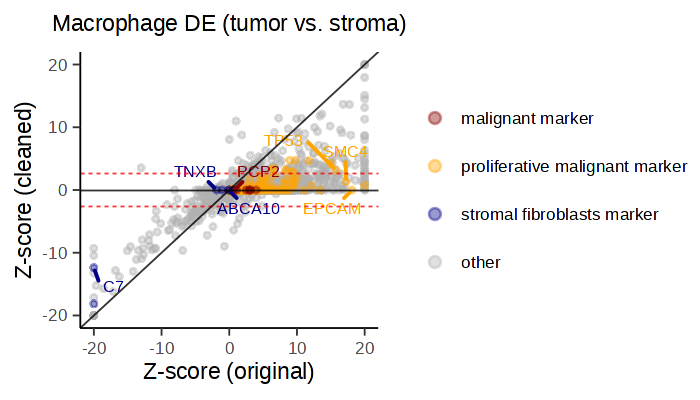

In [108]:
options(repr.plot.width = 3.5, repr.plot.height = 2, repr.plot.res = 200)

#### plot DE comparison
z_thresh <- qnorm(.01/2,lower.tail = FALSE)
tmp <- cbind.data.frame(de_out_orig[,'Z'],de_out_cln[,'Z'])
colnames(tmp) <- c('orig','clean')
rownames(tmp) <- rownames(de_out_orig)

## trying to color points by tumor marker set belonging
tmp$markers <- sapply(rownames(tmp),function(x){
  if (x %in% all_markers_list[['Tumor Cells']]) {
    return('malignant marker')
  } else if (x %in% all_markers_list[['Proliferative Tumor Cells']]) {
    return('proliferative malignant marker')
  } else if (x %in% all_markers_list[['Stromal Associated Fibroblasts']]) {
    return('stromal fibroblasts marker')
  } else {
    return('other')
  }
})

genes_to_label <- c('SMC4','TP53','EPCAM','PCP2','ABCA10','C7','TNXB')
ndx_lab <- match(genes_to_label,rownames(tmp))
genes_to_label <- genes_to_label[!is.na(ndx_lab)]
ndx_lab <- ndx_lab[!is.na(ndx_lab)]
tmp$glab <- NA
tmp[ndx_lab,'glab'] <- genes_to_label
z_upper_thresh <- 20
tmp[which(tmp$orig>z_upper_thresh),'orig'] <- z_upper_thresh
tmp[which(tmp$orig<(-z_upper_thresh)),'orig'] <- -z_upper_thresh
tmp[which(tmp$clean>z_upper_thresh),'clean'] <- z_upper_thresh
tmp[which(tmp$clean<(-z_upper_thresh)),'clean'] <- -z_upper_thresh
tmp$markers <- factor(tmp$markers,levels=c('malignant marker','proliferative malignant marker','stromal fibroblasts marker','other'))
myColors <- c('red4','orange','blue4','grey70')
p <- ggplot(tmp,aes(x=orig,y=clean,color=markers,label=glab)) +
  rasterize(geom_point(data=tmp[tmp$markers=='other',],alpha=gg_point_alpha/2,size=gg_point_size),dpi=dpi) +
  rasterize(geom_point(data=tmp[tmp$markers=='proliferative malignant marker',],alpha=gg_point_alpha/2,size=gg_point_size),dpi=dpi) +
  rasterize(geom_point(data=tmp[tmp$markers=='malignant marker',],alpha=gg_point_alpha/2,size=gg_point_size),dpi=dpi) +
  rasterize(geom_point(data=tmp[tmp$markers=='stromal fibroblasts marker',],alpha=gg_point_alpha/2,size=gg_point_size),dpi=dpi) +
  geom_text_repel(size=geom_text_size, family=font_choice, show.legend = FALSE,min.segment.length = 0) +
  ggtitle('Macrophage DE (tumor vs. stroma)') +
  xlab('Z-score (original)') +
  ylab('Z-score (cleaned)') +
  geom_hline(yintercept = z_thresh,color='red',linetype='dashed',linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_hline(yintercept = -1*z_thresh,color='red',linetype='dashed',linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_hline(yintercept = 0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_abline(slope = 1,intercept=0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  scale_colour_manual(breaks = c('malignant marker','proliferative malignant marker','stromal fibroblasts marker','other'), values = myColors) +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank()) +
  legend_mod

p

In [109]:
pdf(OutputPath('oc_de_compare.pdf'), useDingbats=FALSE, width=3.5, height=2)
p
dev.off()

Warning message:
“Removed 5094 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


png 
  2

In [94]:
### now testing for enriched gene sets in both de results
m_df <- data.frame()
m_df <- rbind(m_df,msigdbr::msigdbr(species = "Homo sapiens",
                                    category = "C5", subcategory = "BP"))
my_pathways <- split(m_df$gene_symbol, f = m_df$gs_name)

mystats <- abs(de_out_orig$Z)
# mystats <- de_out_orig$M
names(mystats) <- rownames(de_out_orig)
fgsea_res_orig <- fgsea::fgsea(pathways = my_pathways,
                               stats = mystats,
                               minSize=10,
                               maxSize=500,
                               eps=0,
                               gseaParam=0,
                               scoreType = "pos")
# fgsea_res_orig <- fgsea::fgsea(pathways = my_pathways,
#                                stats = mystats,
#                                minSize=10,
#                                maxSize=500,
#                                eps=0,
#                                gseaParam=0)
rownames(fgsea_res_orig) <- fgsea_res_orig$pathway

mystats <- abs(de_out_cln$Z)
# mystats <- de_out_cln$M
names(mystats) <- rownames(de_out_cln)
fgsea_res_clean <- fgsea::fgsea(pathways = my_pathways,
                                stats = mystats,
                                minSize=10,
                                maxSize=500,
                                eps=0,
                                gseaParam=0,
                                scoreType = "pos")
# fgsea_res_clean <- fgsea::fgsea(pathways = my_pathways,
#                                 stats = mystats,
#                                 minSize=10,
#                                 maxSize=500,
#                                 eps=0,
#                                 gseaParam=0)
rownames(fgsea_res_clean) <- fgsea_res_clean$pathway



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (45.52% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (2.14% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


Warning message:
“Removed 3702 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


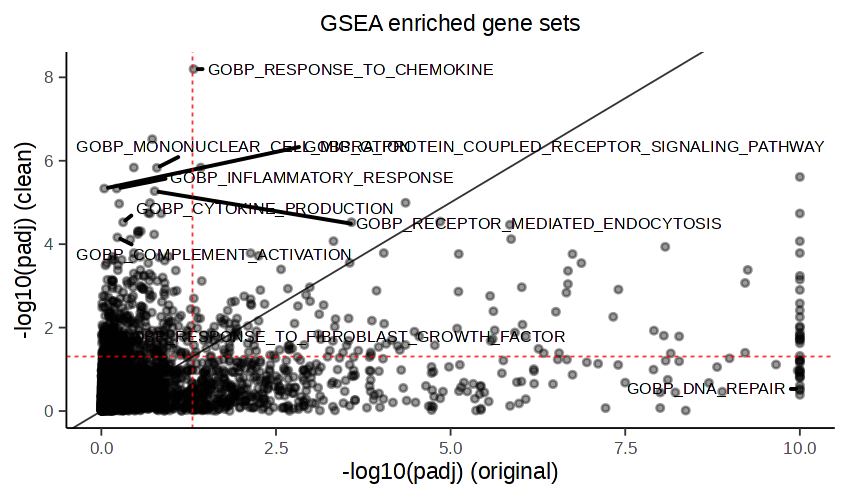

In [113]:
options(repr.plot.width = 4.25, repr.plot.height = 2.5, repr.plot.res = 200)

## plot GSEA comparison
tmp <- cbind.data.frame(-log10(fgsea_res_clean[,'padj']),-log10(fgsea_res_orig[,'padj']))
colnames(tmp) <- c('clean','orig')
upper_lim <- 10
tmp[tmp>upper_lim] <- upper_lim
tmp$pathway <- fgsea_res_clean$pathway
tmp$gslab <- NA
ndx_lab <- which(tmp$pathway %in% c('GOBP_RESPONSE_TO_CHEMOKINE',
                                   'GOBP_MONONUCLEAR_CELL_MIGRATION',
                                   'GOBP_RESPONSE_TO_FIBROBLAST_GROWTH_FACTOR',
                                   'GOBP_G_PROTEIN_COUPLED_RECEPTOR_SIGNALING_PATHWAY',
                                   'GOBP_INFLAMMATORY_RESPONSE',
                                   'GOBP_RECEPTOR_MEDIATED_ENDOCYTOSIS',
                                   'GOBP_CYTOKINE_PRODUCTION',
                                   'GOBP_COMPLEMENT_ACTIVATION',
                                   'GOBP_DNA_REPAIR'))
tmp$gslab[ndx_lab] <- fgsea_res_clean$pathway[ndx_lab]
p <- ggplot(tmp,aes(x=orig,y=clean,label=gslab)) +
  geom_point(alpha=gg_point_alpha/2,size=gg_point_size) +
  geom_text_repel(size=geom_text_size,show.legend = FALSE,family=font_choice,min.segment.length = 0) +
  geom_vline(xintercept=-log10(.05),color='red',linetype='dashed',linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_hline(yintercept=-log10(.05),color='red',linetype='dashed',linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_abline(slope = 1,intercept=0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  xlab('-log10(padj) (original)') +
  ylab('-log10(padj) (clean)') +
  ggtitle('GSEA enriched gene sets') +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank()) +
  legend_mod

p

In [114]:
pdf(OutputPath('oc_gsea_compare.pdf'), useDingbats = FALSE, width = 4.25, height = 2.5)
p
dev.off()

Warning message:
“Removed 3702 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


png 
  2